In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install lightning
from lightning.pytorch import seed_everything

seed_everything(42, workers=True)

ModuleNotFoundError: No module named 'lightning'

In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import HelocDataset
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.metrics import CFMetrics

In [3]:
dataset = HelocDataset("../data/heloc.csv")

In [4]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 2)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=128, shuffle=True),
#     dataset.test_dataloader(batch_size=128, shuffle=False),
#     epochs=5000,
#     patience=100,
#     lr=1e-3,
#     checkpoint_path="heloc_disc_model.pt",
# )
disc_model.load("heloc_disc_model.pt")

In [5]:
# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=256, shuffle=True),
#     dataset.test_dataloader(batch_size=256, shuffle=False),
#     epochs=5000,
#     patience=100,
#     checkpoint_path="disc_model.pt",
# )
# # disc_model.load("disc_model.pt")

In [6]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.7169620253164557


In [7]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [8]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

# gen_model.fit(
#     train_dataloader,
#     train_dataloader,
#     learning_rate=1e-3,
#     patience=100,
#     num_epochs=500,
#     checkpoint_path="heloc_flow.pth",
# )
gen_model.load("heloc_flow.pth")

In [9]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [10]:
dataset.actionable_features = [4, 17, 18, 19, 20]
dataset.not_actionable_features = [
    i for i in range(dataset.X_train.shape[1]) if i not in dataset.actionable_features
]
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(),
    # actionable_features=None,
    # TODO: poprawa nazewnictwa
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=3000,
    lr=0.003,
    patience=300,
    alpha=100,
    alpha_s=1000,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

  0%|                                                                                                         …

Correct: 898/1040
6


/opt/homebrew/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


{'coverage': 1.0,
 'validity': 0.9778846153846154,
 'actionability': 0.0,
 'sparsity': 0.21739130434782608,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.5610224582425074,
 'proximity_continuous_manhattan': 1.0456884582872679,
 'proximity_continuous_euclidean': 0.5610224582425074,
 'proximity_continuous_mad': 27.13974198331132,
 'proximity_l2_jaccard': 0.5610224582425074,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.09615384615384616,
 'log_density_cf': 9.419817,
 'log_density_test': 25.399448,
 'lof_scores_cf': 1.6273726,
 'lof_scores_test': 1.0886608,
 'isolation_forest_scores_cf': 0.0023390172607932664,
 'isolation_forest_scores_test': 0.05262575822461268}

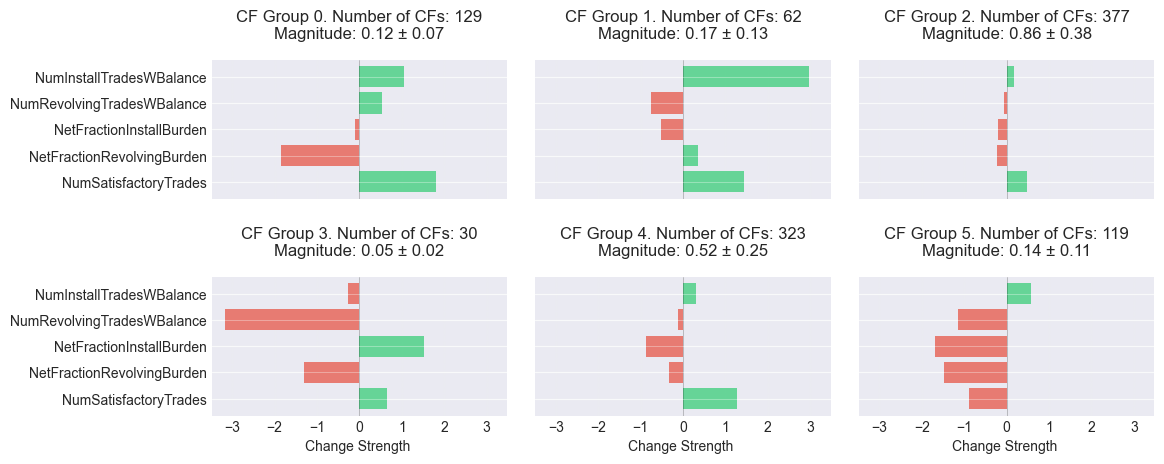

In [20]:
plt.style.use('seaborn-v0_8-darkgrid')  # Use seaborn style for better default aesthetics

# Create figure with shared axes
fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
axes = axes.ravel()

# Set a clean background style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Find global max absolute value for symmetric scaling
global_max_abs = max(
    abs(D[:, dataset.actionable_features].min().item()),
    abs(D[:, dataset.actionable_features].max().item())
)

groups = S.argmax(dim=1)

# Get feature names for y-labels
feature_names = dataset.feature_columns[dataset.actionable_features]

# Define better colors
pos_color = '#2ecc71'  # A softer green
neg_color = '#e74c3c'  # A softer red
grid_color = '#ecf0f1'  # Light gray for grid

for i in range(D.shape[0]):
    data = D[i, dataset.actionable_features].detach().numpy()
    y_pos = np.arange(len(feature_names))
    
    # Split data into positive and negative values
    positive_mask = data >= 0
    negative_mask = data < 0
    
    # Plot bars with alpha for better visibility
    axes[i].barh(y_pos[positive_mask], data[positive_mask], 
                 color=pos_color, align='center', alpha=0.7,
                 edgecolor='none')
    axes[i].barh(y_pos[negative_mask], data[negative_mask], 
                 color=neg_color, align='center', alpha=0.7,
                 edgecolor='none')
    
    # Add vertical line at x=0
    axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Set y-labels with improved font
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(feature_names, fontsize=10, fontfamily='sans-serif')

    # Set x-labels with improved font
    if i > 2:
        axes[i].set_xlabel('Change Strength ', fontsize=10)
    
    # Calculate statistics
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    
    # Improved title with better formatting
    axes[i].set_title(f"CF Group {i}. Number of CFs: {n_vectors}\n"
                     f"Magnitude: {mean_magn:.2f} ± {std_magn:.2f}",
                     fontsize=12, pad=15)
    
    # Set consistent x-axis limits with padding
    padding = global_max_abs * 0.1
    axes[i].set_xlim(-global_max_abs - padding, global_max_abs + padding)
    
    # Add grid with better styling
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.3, color=grid_color)
    axes[i].set_axisbelow(True)  # Put grid below bars
    
    # Remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    # Lighten the remaining spines
    axes[i].spines['left'].set_color('#bdc3c7')
    axes[i].spines['bottom'].set_color('#bdc3c7')
    
    # Add light horizontal lines for better readability
    for pos in y_pos:
        axes[i].axhline(y=pos, color='#ecf0f1', linestyle='-', linewidth=0.5, alpha=0.5)

# Adjust layout
plt.tight_layout(pad=2.0)
plt.savefig('heloc_explanations.pdf')

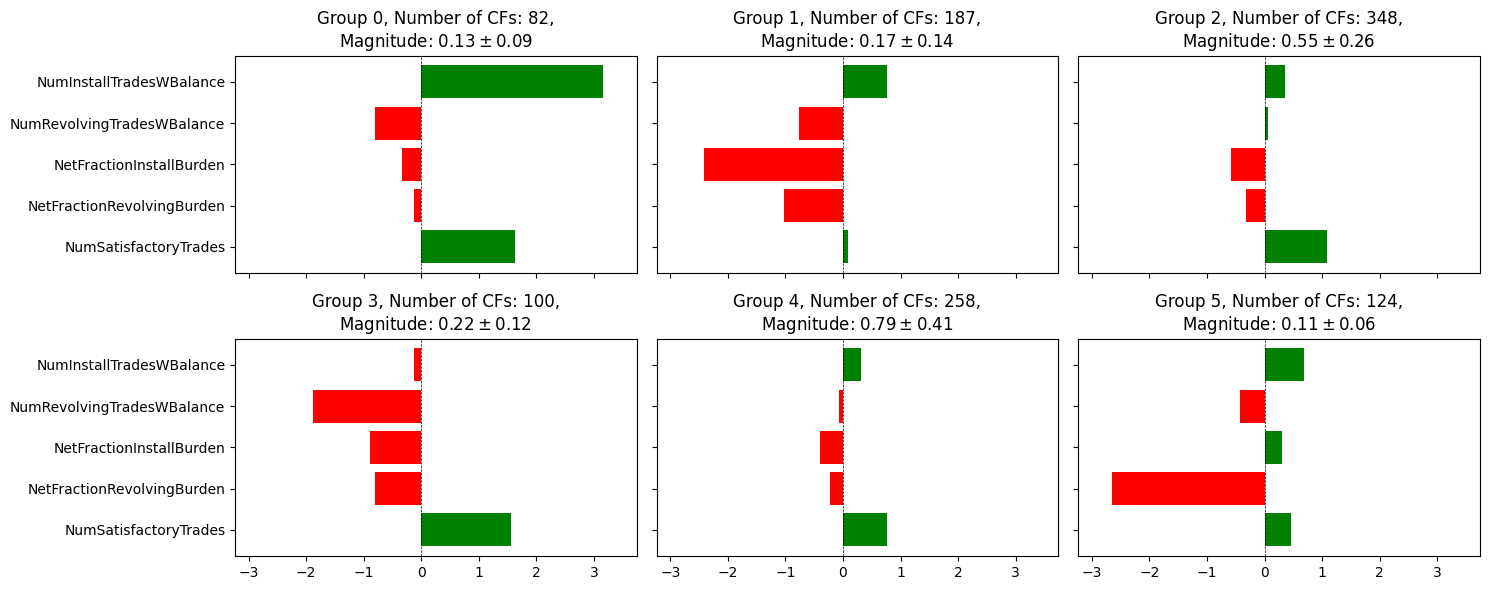

In [30]:
# Create figure with shared axes
fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

# Find global min and max for consistent y-axis scaling
global_min = min(D[:, dataset.actionable_features].min().item(), 0)
global_max = max(D[:, dataset.actionable_features].max().item(), 0)

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    data = D[i, dataset.actionable_features].detach().numpy()
    y_pos = np.arange(len(dataset.actionable_features))
    
    # Split data into positive and negative values
    positive_mask = data >= 0
    negative_mask = data < 0

    # Set y-labels
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(dataset.feature_columns[dataset.actionable_features])
    
    # Plot positive bars
    axes[i].barh(y_pos[positive_mask], data[positive_mask], color='green', align='center')
    # Plot negative bars
    axes[i].barh(y_pos[negative_mask], data[negative_mask], color='red', align='center')
    
    # Add vertical line at x=0
    axes[i].axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    
    axes[i].set_title(f"Group {i}, Number of CFs: {n_vectors},\nMagnitude: ${mean_magn:.2f} \pm {std_magn:.2f}$")
    
    # Set consistent x-axis limits with some padding
    padding = (global_max - global_min) * 0.1
    axes[i].set_xlim(global_min - padding, global_max + padding)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

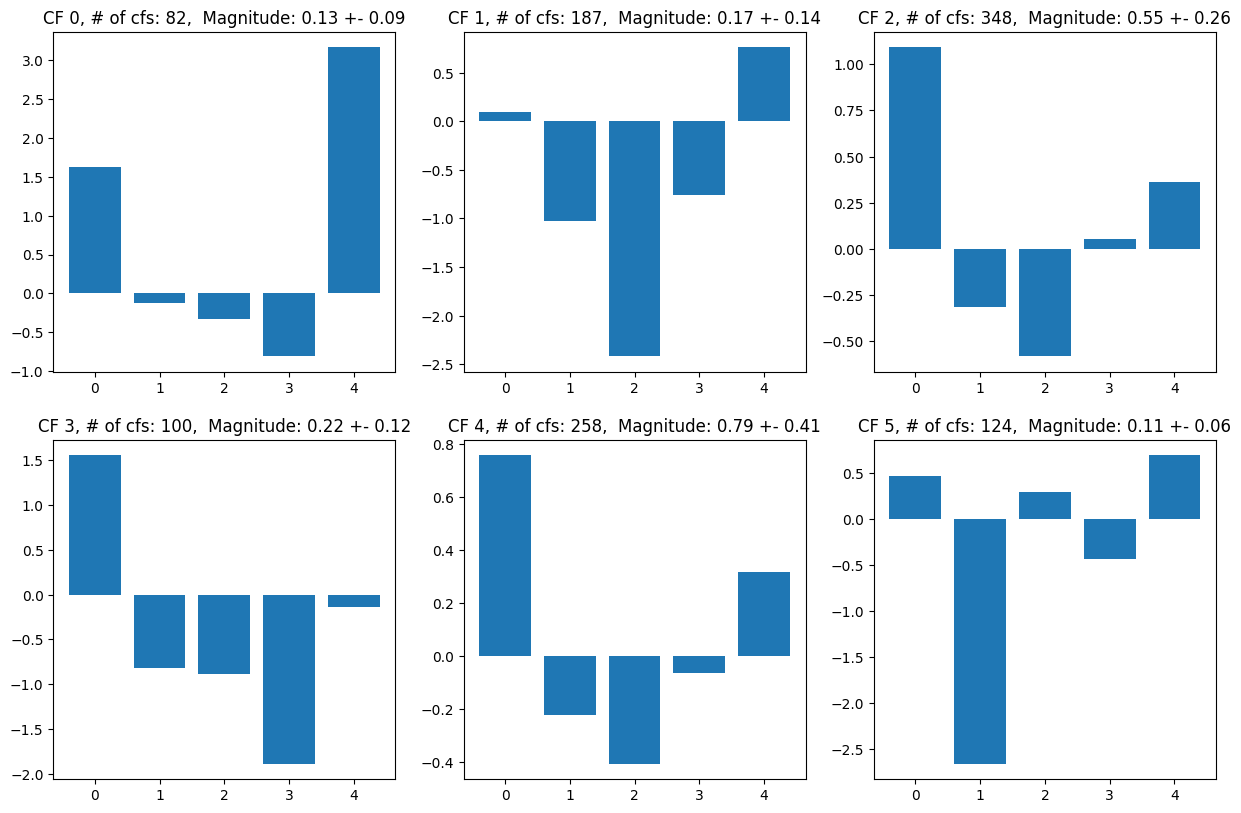

In [12]:
plt.figure(figsize=(15, 15))

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.bar(
        range(len(dataset.actionable_features)),
        D[i, dataset.actionable_features].detach().numpy(),
    )
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    plt.title(
        f"CF {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )

In [ ]:
import matplotlib.pyplot as plt

# First subset
subset_0 = X_test_origin[S.argmax(dim=1) == 0]
mean_values_0 = subset_0.mean(axis=0)
std_values_0 = subset_0.std(axis=0)

# Second subset
subset_1 = X_test_origin[S.argmax(dim=1) == 3]
mean_values_1 = subset_1.mean(axis=0)
std_values_1 = subset_1.std(axis=0)

fig, axes = plt.subplots(1, len(mean_values_0), figsize=(25, 5), sharey=True)

for i in range(len(mean_values_0)):
    axes[i].bar(
        0, mean_values_0[i], yerr=std_values_0[i], capsize=5, color="blue", alpha=0.7
    )
    axes[i].bar(
        1, mean_values_1[i], yerr=std_values_1[i], capsize=5, color="green", alpha=0.7
    )
    axes[i].set_xticks([0, 1])
    # axes[i].set_xticklabels(['Subset 0', 'Subset 1'])
    # axes[i].set_title(f'Feature {i}')

fig.suptitle("Mean and Std of Features for Subsets 0 and 3")
plt.show()